DSCI 632

Summer 2022

Final Project: PySpark ML Student Performance

**Team: John Johnson, Katy Matulay, Justin Minnion**

In [0]:
# Import Libraries for Databricks, note that PySpark is already pre-installed and instantiated
from pyspark.sql.functions import isnan, when, count, col, mean, udf, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType, DoubleType, FloatType

#graphics
import seaborn as sns
import matplotlib.pyplot as plt

#ML Libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np



## EDA

In [0]:
#load dataset into DF1
df1 = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/km3868@drexel.edu/student_data.csv")

In [0]:
df1.show(1,truncate= True)

+------+---+---+-------+-------+-------+----+----+-------+-------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|   Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+-------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home|teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6|
+------+---+---+-------+-------+-------+----

In [0]:
# view dataframe ~10 columns at a time
df1.select([this_col for this_col in df1.columns[:10]]).show(5)
df1.select([this_col for this_col in df1.columns[10:20]]).show(5)
df1.select([this_col for this_col in df1.columns[20:]]).show(5)

+------+---+---+-------+-------+-------+----+----+-------+--------+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|
+------+---+---+-------+-------+-------+----+----+-------+--------+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|
|    GP|  F| 17|      U|    GT3|      T|   1|   1|at_home|   other|
|    GP|  F| 15|      U|    LE3|      T|   1|   1|at_home|   other|
|    GP|  F| 15|      U|    GT3|      T|   4|   2| health|services|
|    GP|  F| 16|      U|    GT3|      T|   3|   3|  other|   other|
+------+---+---+-------+-------+-------+----+----+-------+--------+
only showing top 5 rows

+------+--------+----------+---------+--------+---------+------+----+----------+-------+
|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|
+------+--------+----------+---------+--------+---------+------+----+----------+-------+
|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|
|course

In [0]:
df1.describe()
df1.printSchema()


root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

In [0]:
# examine null/nan value counts

null_counts = df1.select([count(when(isnan(this_col) | col(this_col).isNull(), this_col)).alias(this_col) for this_col in df1.columns]).rdd.take(1)

for k, v in null_counts[0].asDict().items():
    print(f"{k}: {v}")

school: 0
sex: 0
age: 0
address: 0
famsize: 0
Pstatus: 0
Medu: 0
Fedu: 0
Mjob: 0
Fjob: 0
reason: 0
guardian: 0
traveltime: 0
studytime: 0
failures: 0
schoolsup: 0
famsup: 0
paid: 0
activities: 0
nursery: 0
higher: 0
internet: 0
romantic: 0
famrel: 0
freetime: 0
goout: 0
Dalc: 0
Walc: 0
health: 0
absences: 0
G1: 0
G2: 0
G3: 0


No null values

In [0]:
#Add a final grade column
eda_rdd = df1.withColumn("final_grade",(col("G1")+col("G2")+col("G3"))/3)
eda_rdd.printSchema()

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

In [0]:
eda_df = df1.toPandas()

In [0]:
eda_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


Out[11]: <AxesSubplot:xlabel='school', ylabel='G3'>

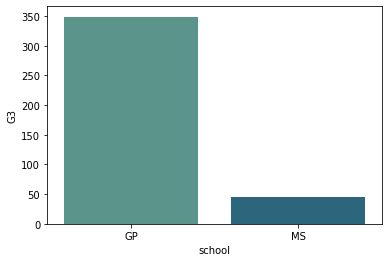

In [0]:
school_comparison = eda_df.groupby("school").agg({"G3": "count"}).reset_index()
sns.barplot(data=school_comparison, x='school', y='G3', palette='crest')

Out[12]: <AxesSubplot:xlabel='sex', ylabel='G3'>

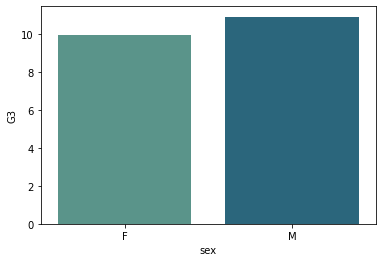

In [0]:
school_comparison = eda_df.groupby("sex").agg({"G3": "mean"}).reset_index()
sns.barplot(data=school_comparison, x='sex', y='G3', palette='crest')

Out[13]: <AxesSubplot:xlabel='Walc', ylabel='G3'>

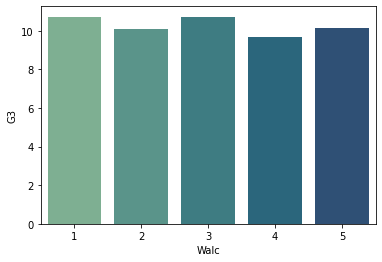

In [0]:
school_comparison = eda_df.groupby("Walc").agg({"G3": "mean"}).reset_index()
sns.barplot(data=school_comparison, x='Walc', y='G3', palette='crest')

In [0]:
df1.groupby(['age']).count().show()

+---+-----+
|age|count|
+---+-----+
| 22|    1|
| 16|  104|
| 20|    3|
| 19|   24|
| 15|   82|
| 17|   98|
| 21|    1|
| 18|   82|
+---+-----+



Out[16]: <AxesSubplot:xlabel='health', ylabel='Count'>

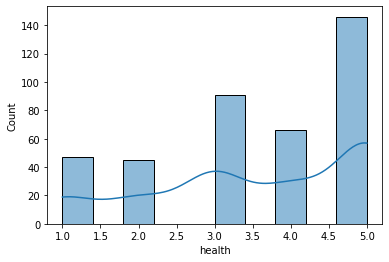

In [0]:
sns.histplot(x='health', data=eda_df, kde=True)

Out[17]: <AxesSubplot:xlabel='G3', ylabel='health'>

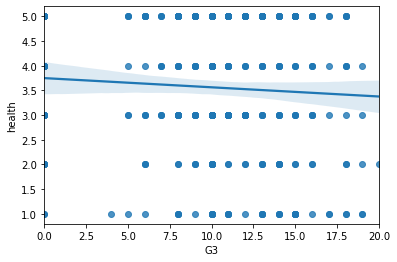

In [0]:
sns.regplot(x='G3', y='health', data=eda_df)

Out[18]: <AxesSubplot:xlabel='studytime', ylabel='G3'>

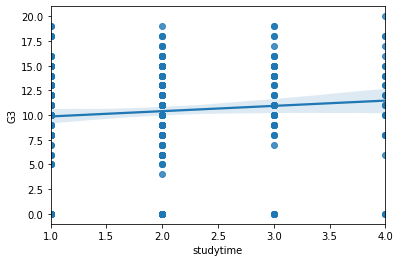

In [0]:
sns.regplot(x='studytime', y='G3', data=eda_df)

Out[19]: <AxesSubplot:xlabel='absences', ylabel='G3'>

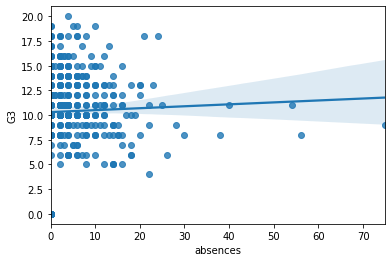

In [0]:
sns.regplot(x='absences', y='G3', data=eda_df)

Out[20]: <AxesSubplot:>

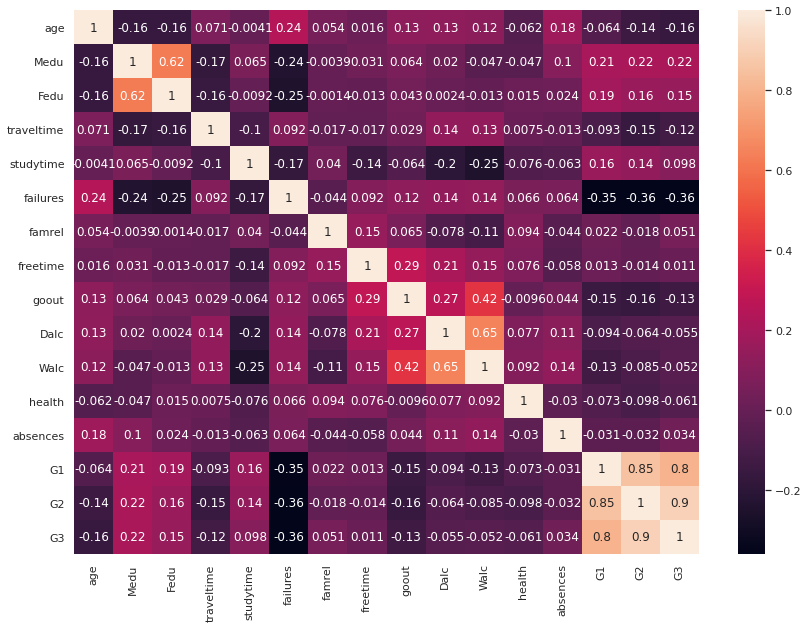

In [0]:
sns.set(rc={'figure.figsize':(14,10)})
sns.heatmap(eda_df[['age', 'famsize', 'Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences','G1','G2','G3']].corr(), annot=True)

Out[21]: <AxesSubplot:>

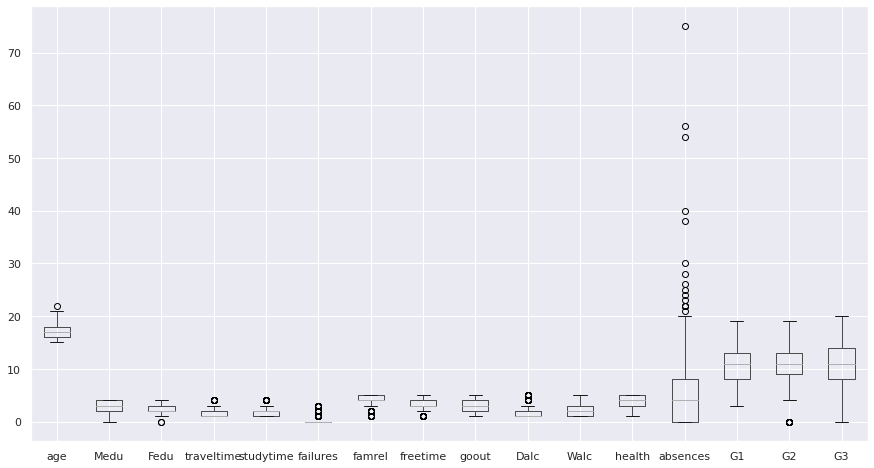

In [0]:
#outliers analysis

plt.figure(figsize=(15,8))
eda_df.boxplot()


Out[22]: <AxesSubplot:xlabel='absences'>

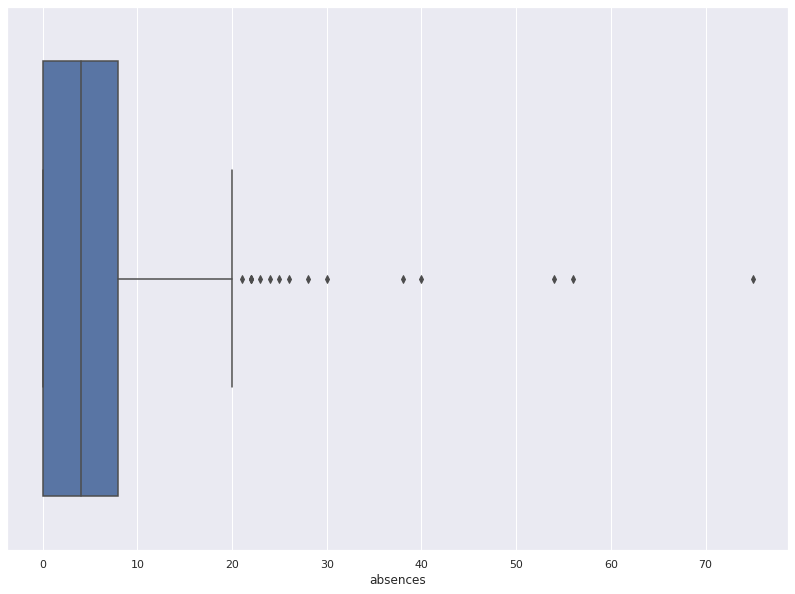

In [0]:
#Looking closer at Absences
sns.boxplot(x='absences', data=eda_df)

## Column level analysis

In [0]:
for col in df1.columns[:30]:
    df1.groupby([col]).count().orderBy([col], ascending = True).show()


+------+-----+
|school|count|
+------+-----+
|    GP|  349|
|    MS|   46|
+------+-----+

+---+-----+
|sex|count|
+---+-----+
|  F|  208|
|  M|  187|
+---+-----+

+---+-----+
|age|count|
+---+-----+
| 15|   82|
| 16|  104|
| 17|   98|
| 18|   82|
| 19|   24|
| 20|    3|
| 21|    1|
| 22|    1|
+---+-----+

+-------+-----+
|address|count|
+-------+-----+
|      R|   88|
|      U|  307|
+-------+-----+

+-------+-----+
|famsize|count|
+-------+-----+
|    GT3|  281|
|    LE3|  114|
+-------+-----+

+-------+-----+
|Pstatus|count|
+-------+-----+
|      A|   41|
|      T|  354|
+-------+-----+

+----+-----+
|Medu|count|
+----+-----+
|   0|    3|
|   1|   59|
|   2|  103|
|   3|   99|
|   4|  131|
+----+-----+

+----+-----+
|Fedu|count|
+----+-----+
|   0|    2|
|   1|   82|
|   2|  115|
|   3|  100|
|   4|   96|
+----+-----+

+--------+-----+
|    Mjob|count|
+--------+-----+
| at_home|   59|
|  health|   34|
|   other|  141|
|services|  103|
| teacher|   58|
+--------+-----+

+--------+

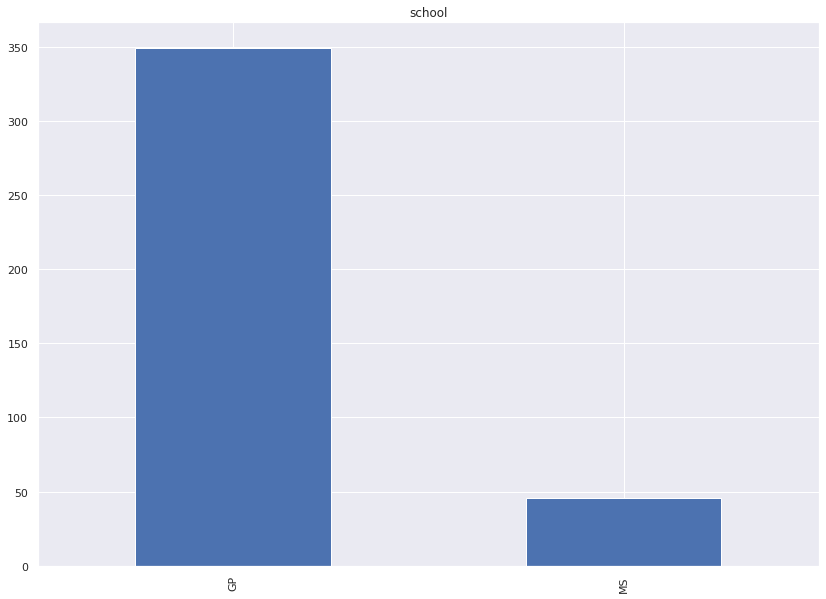

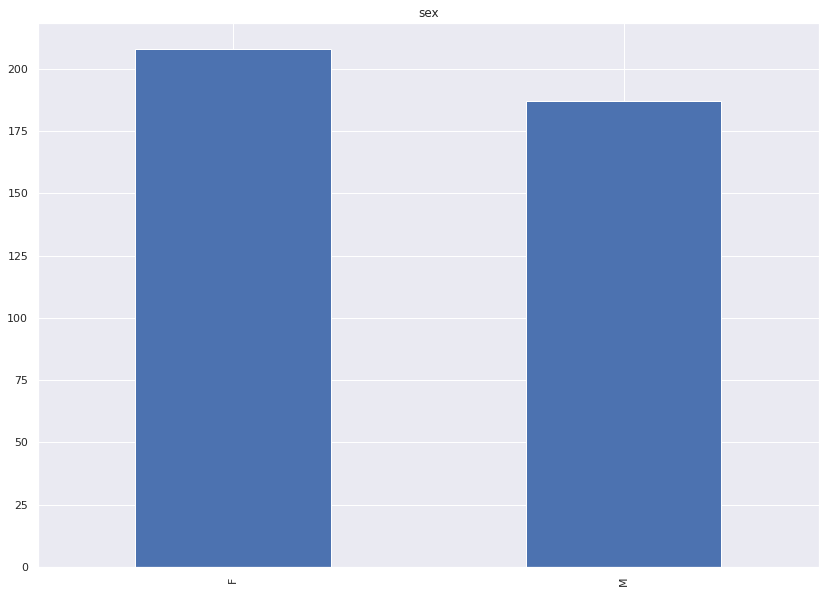

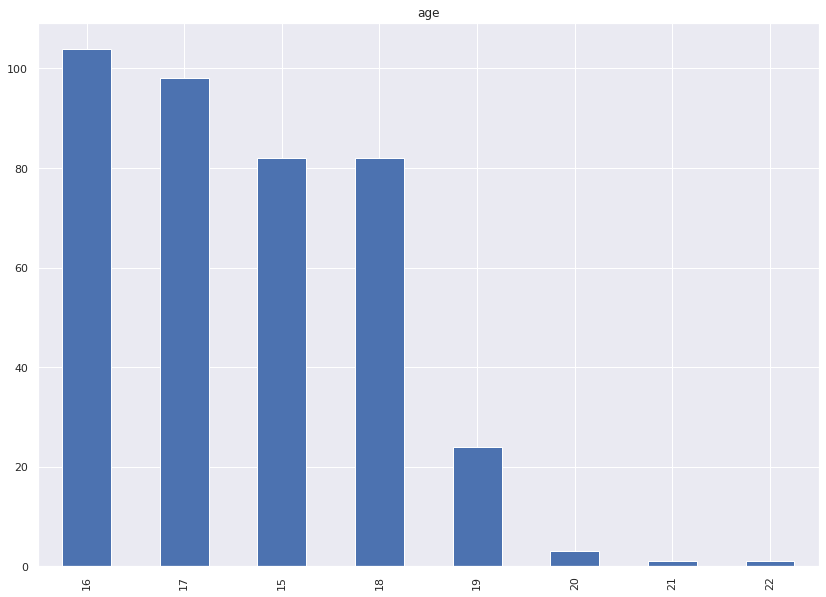

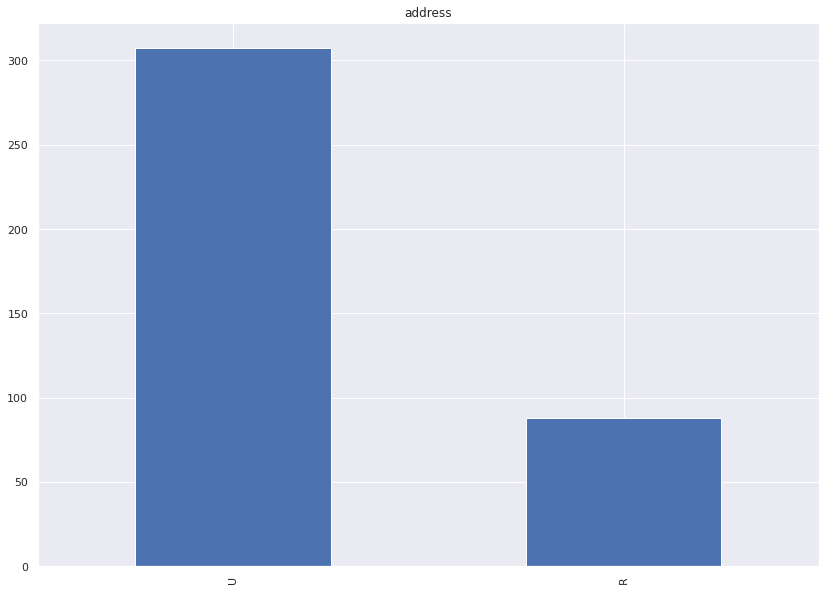

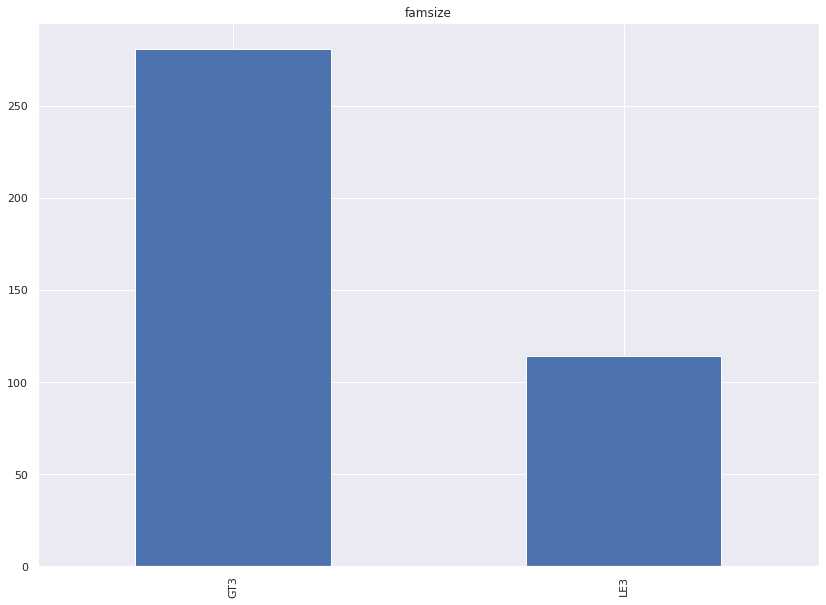

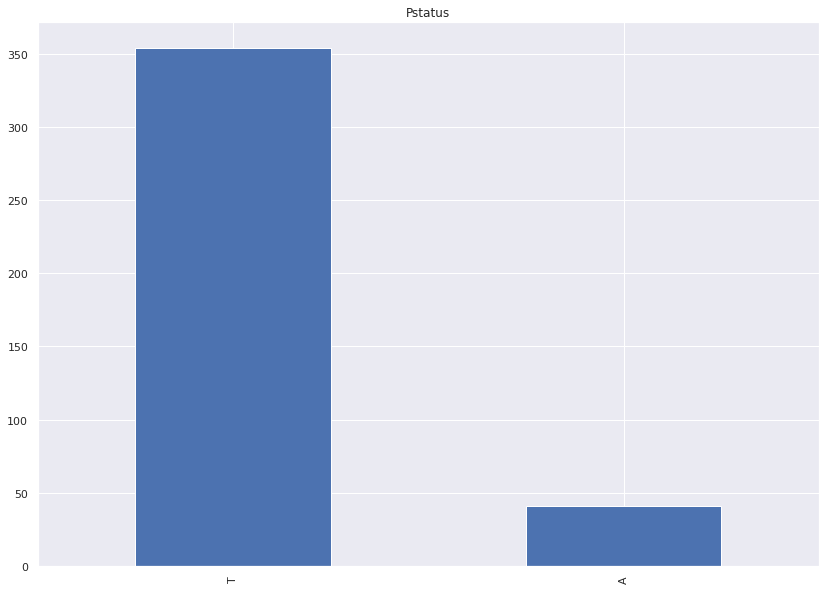

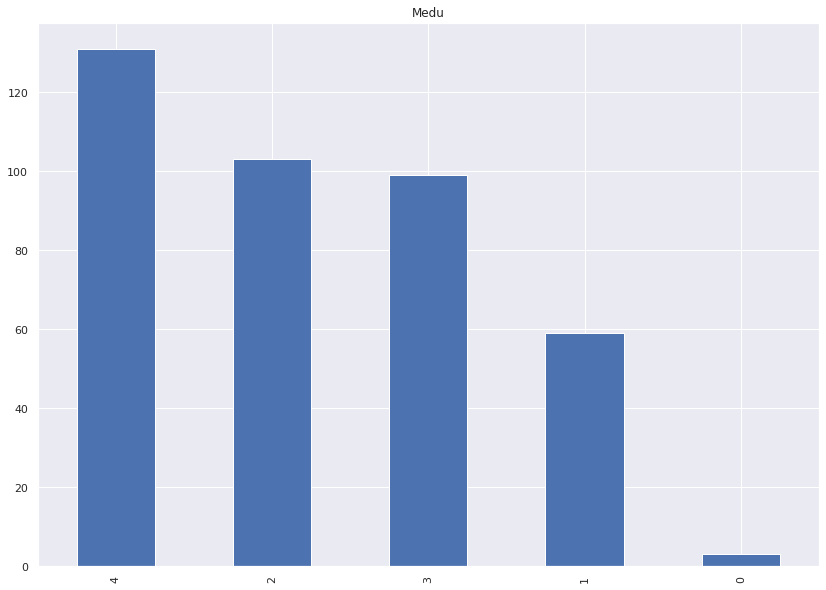

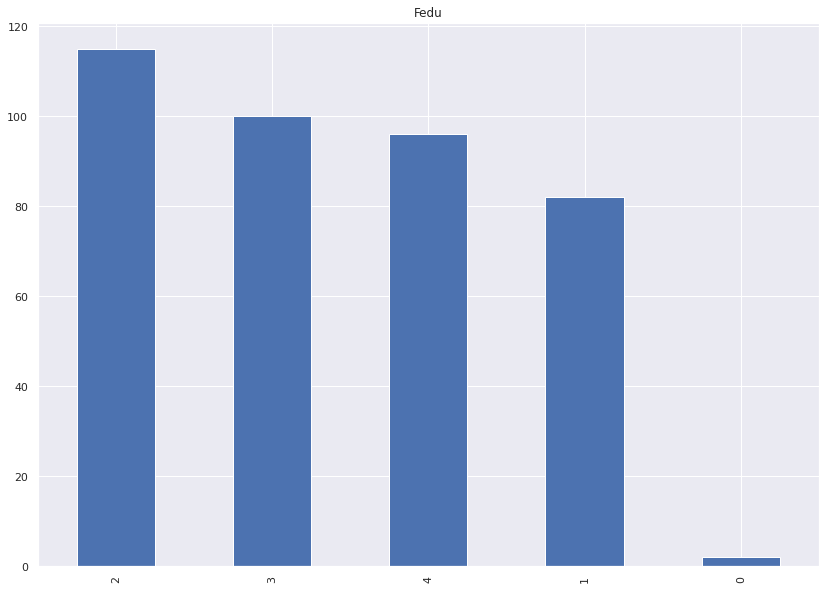

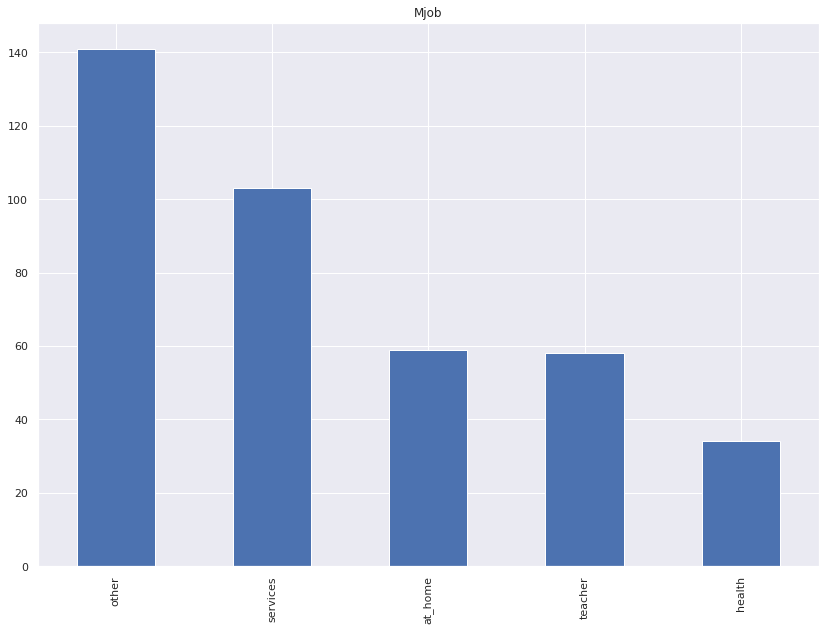

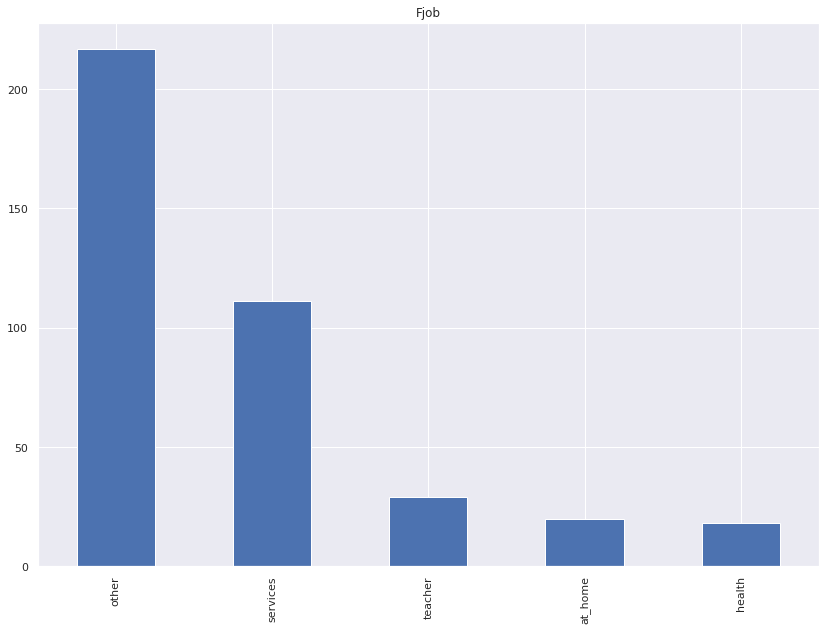

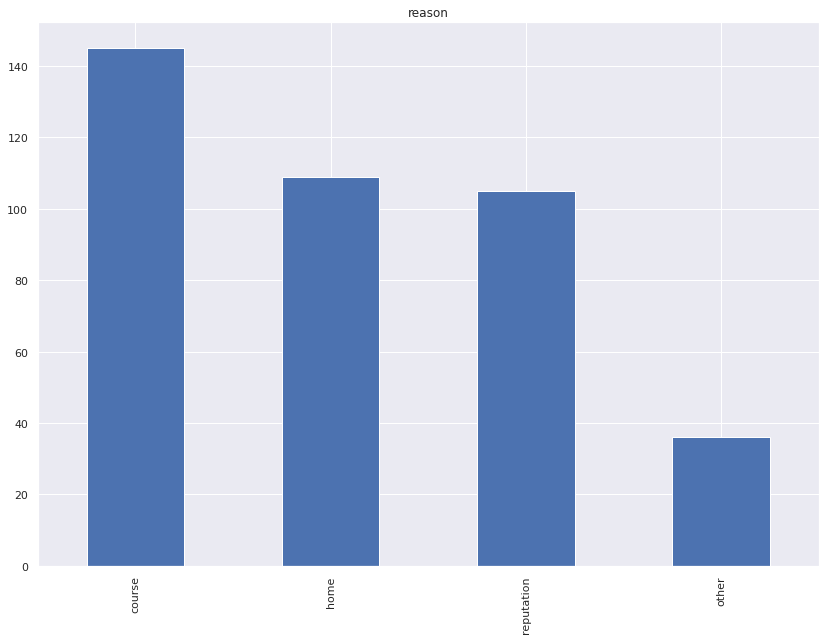

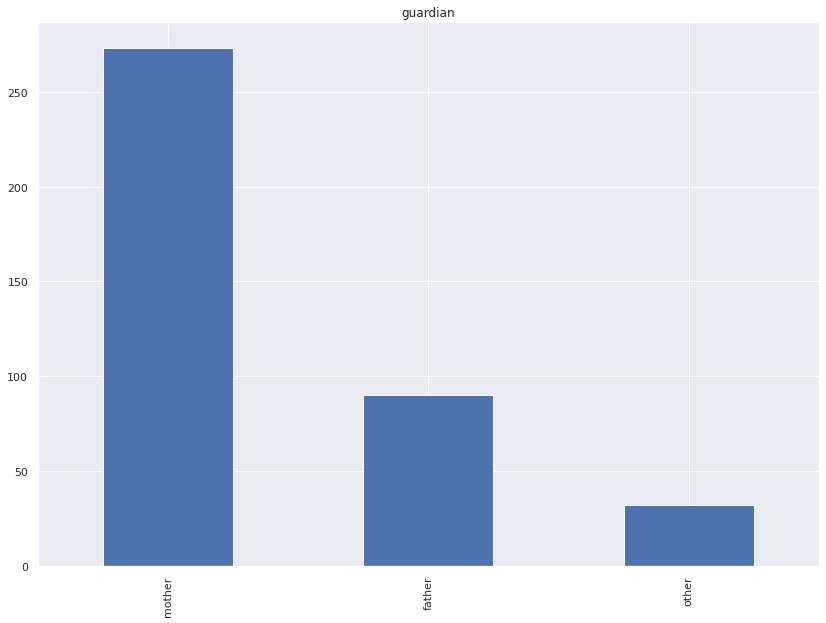

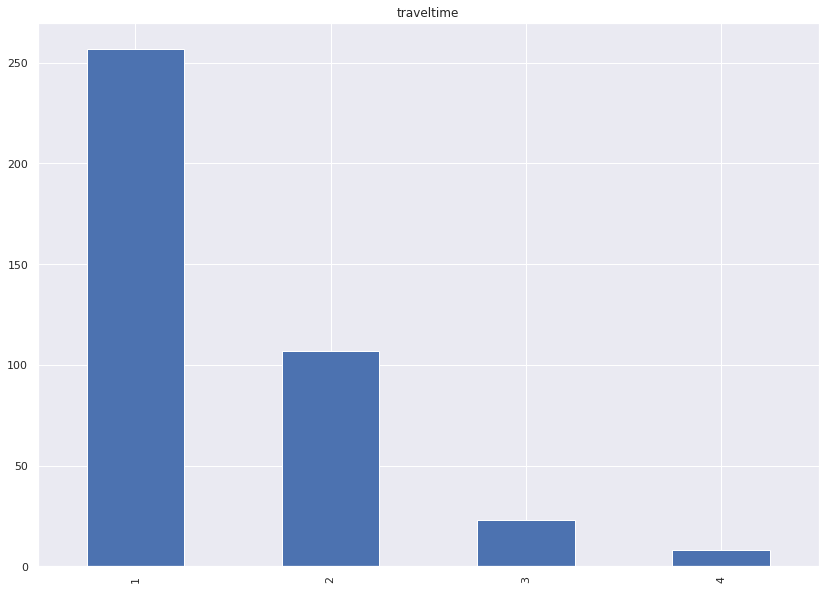

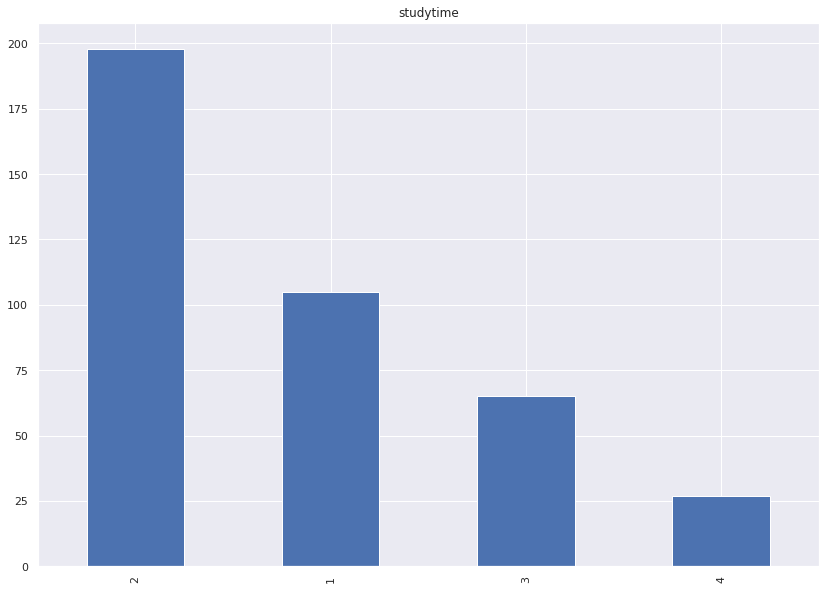

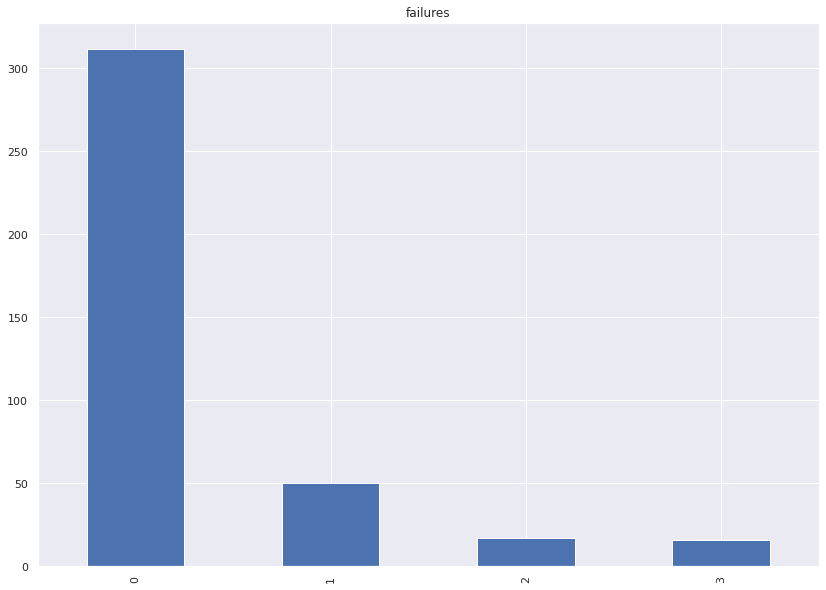

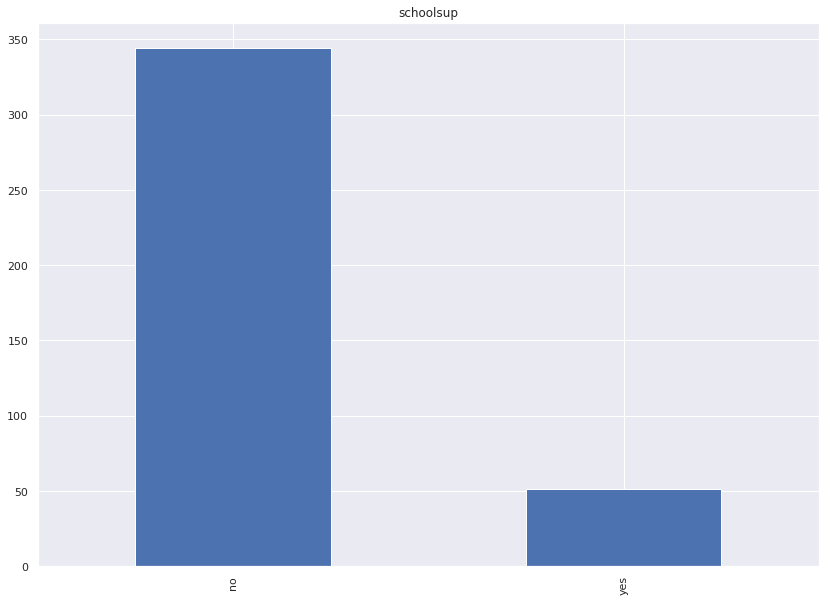

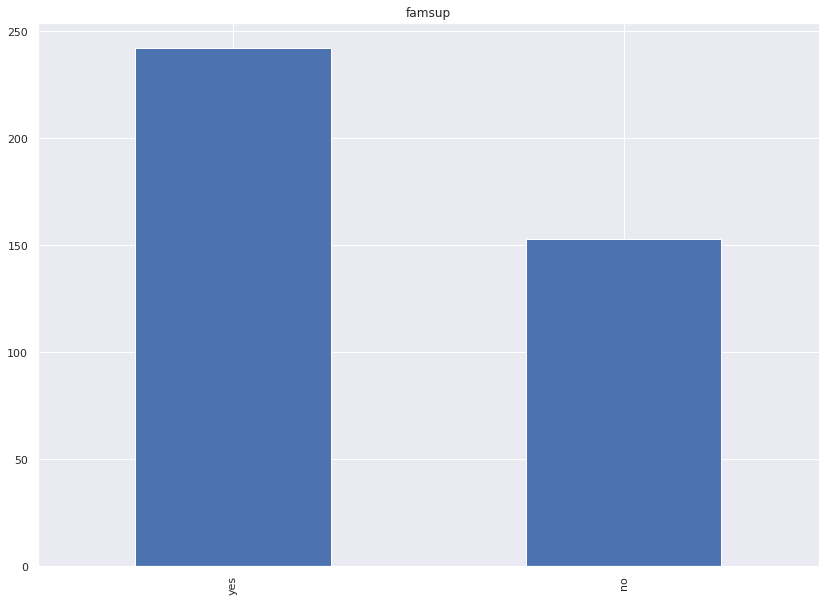

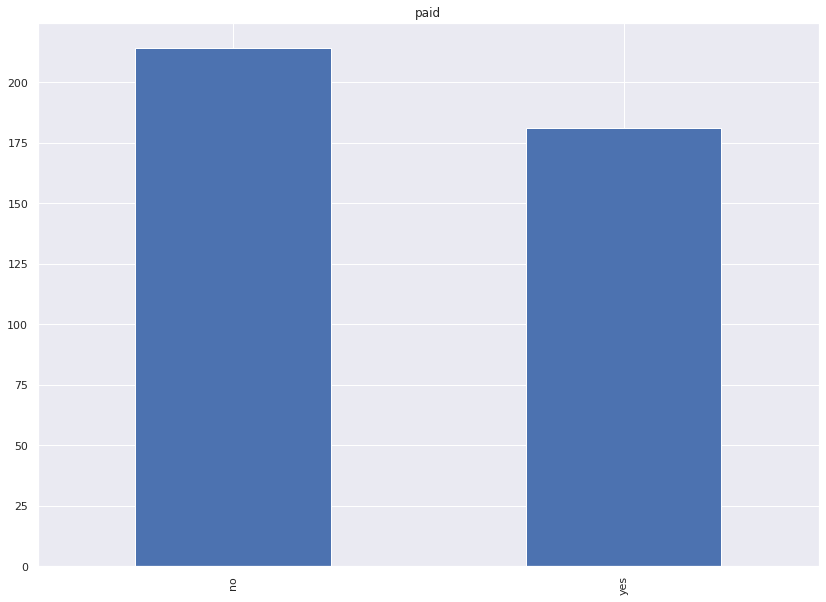

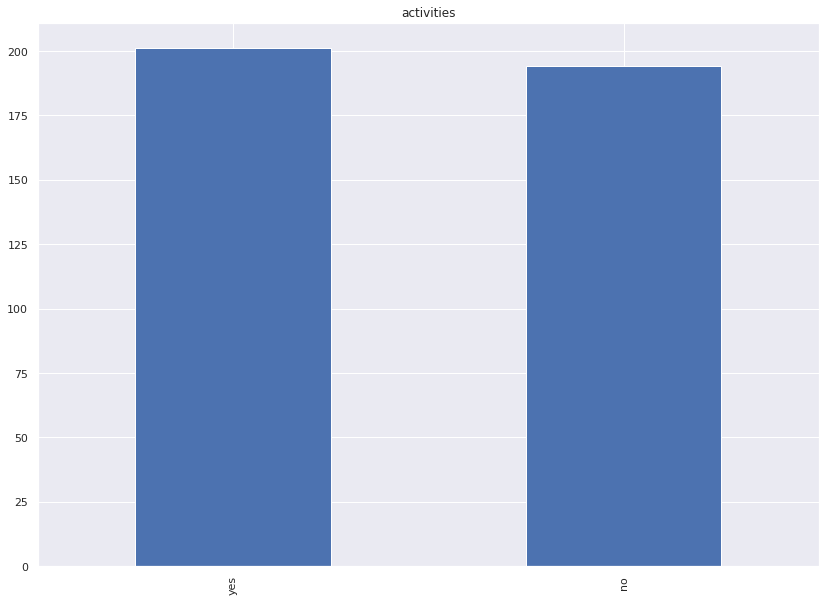

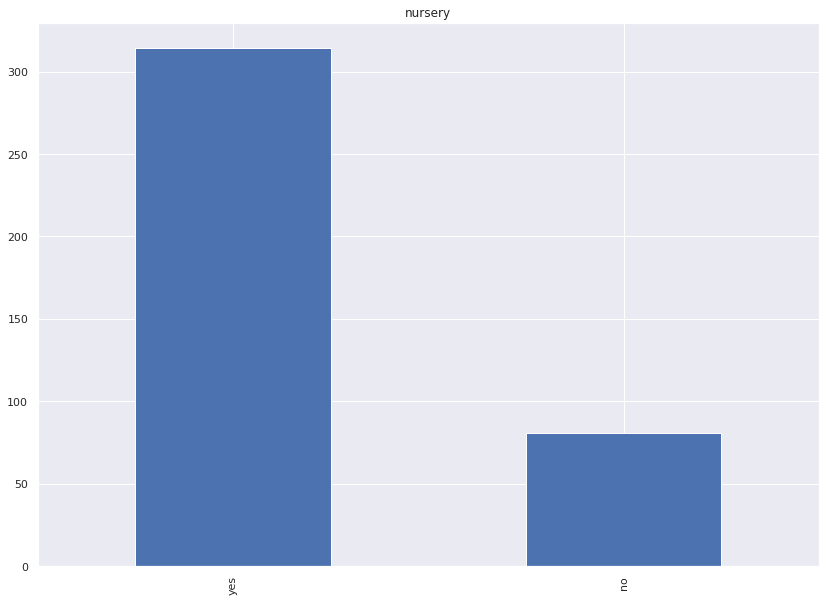

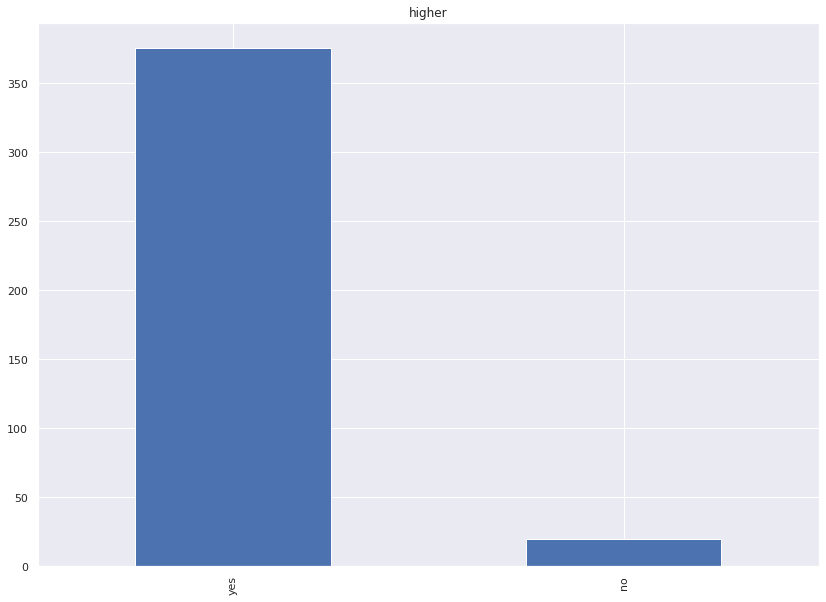

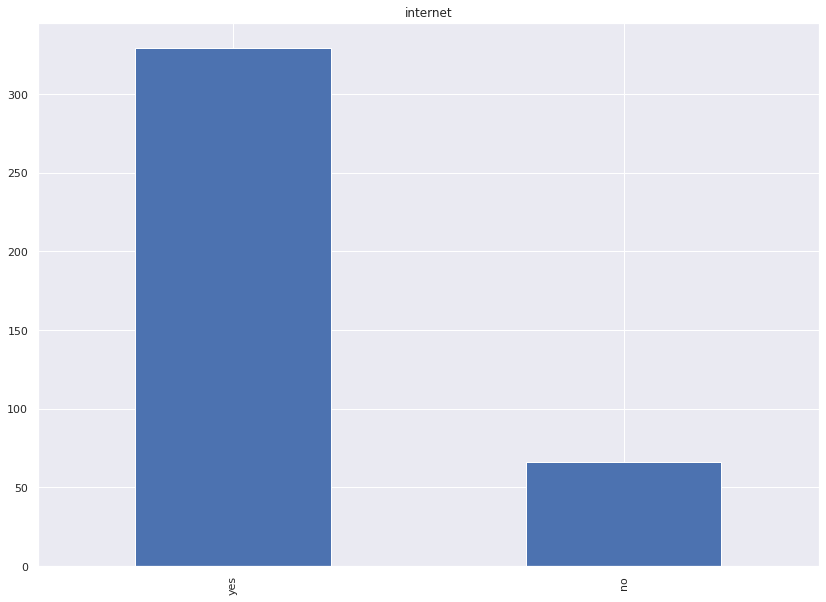

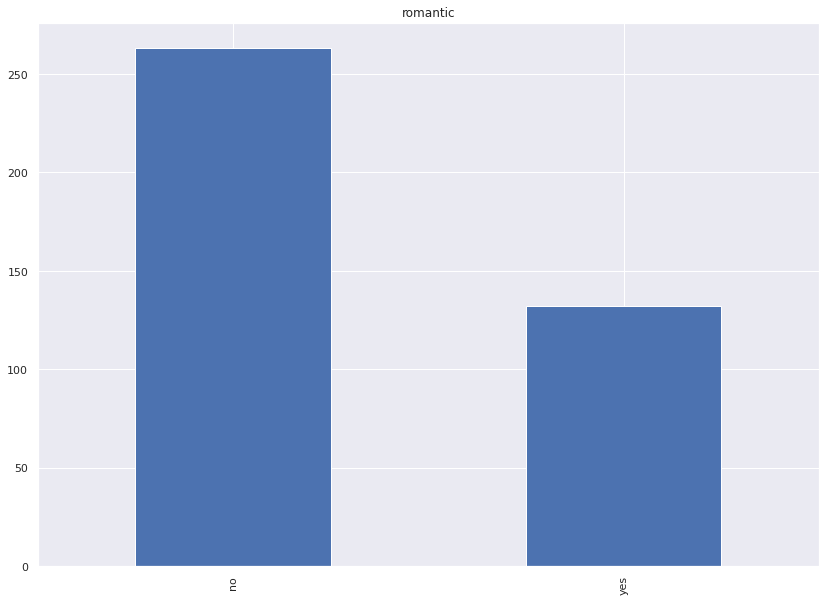

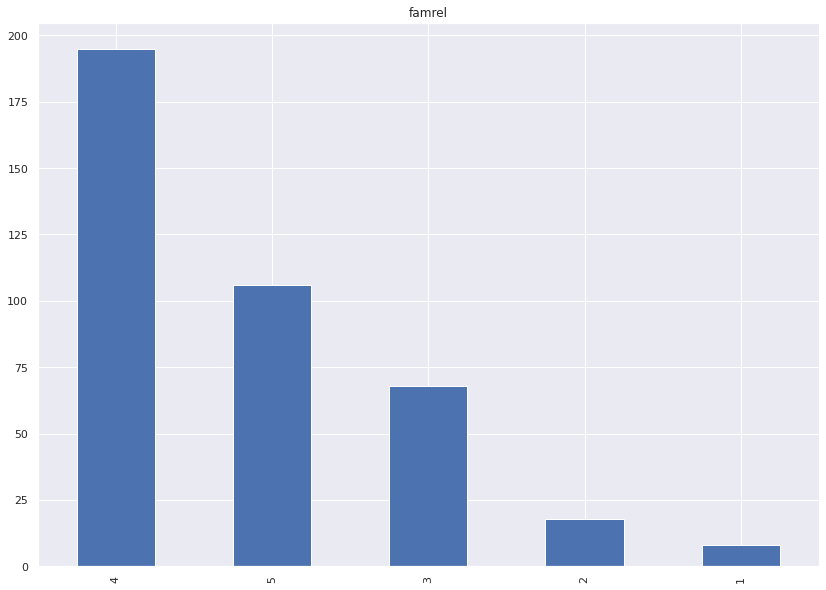

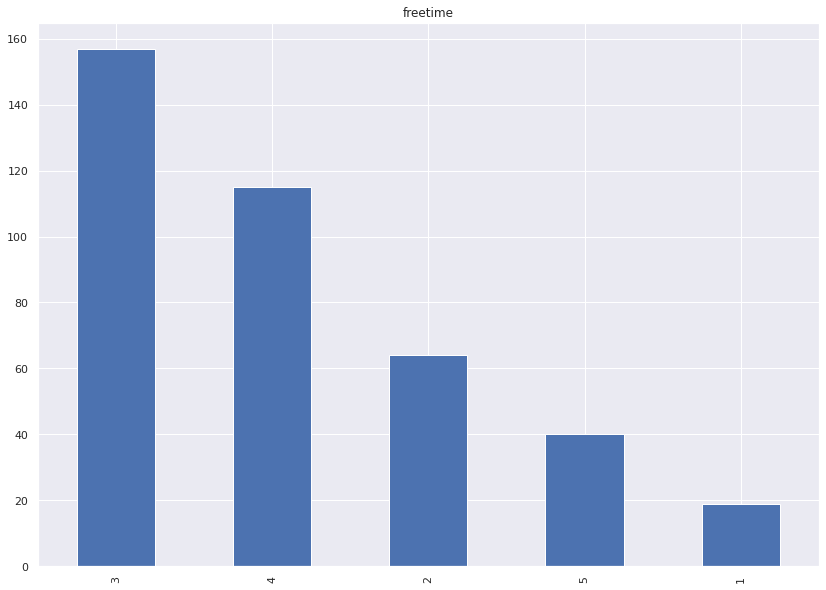

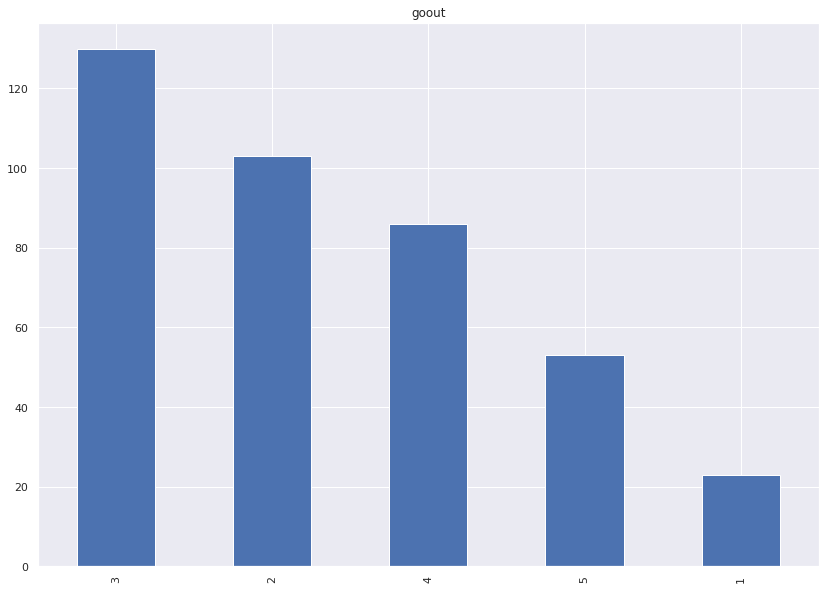

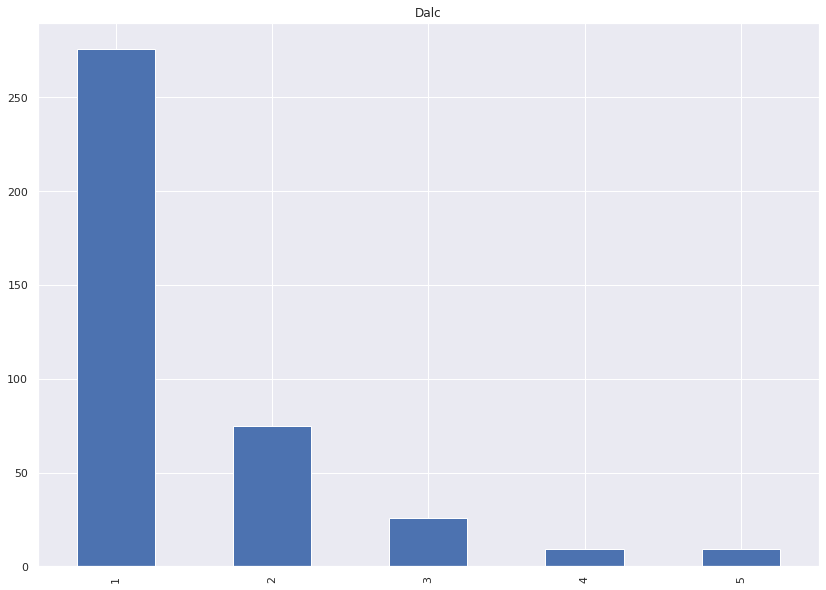

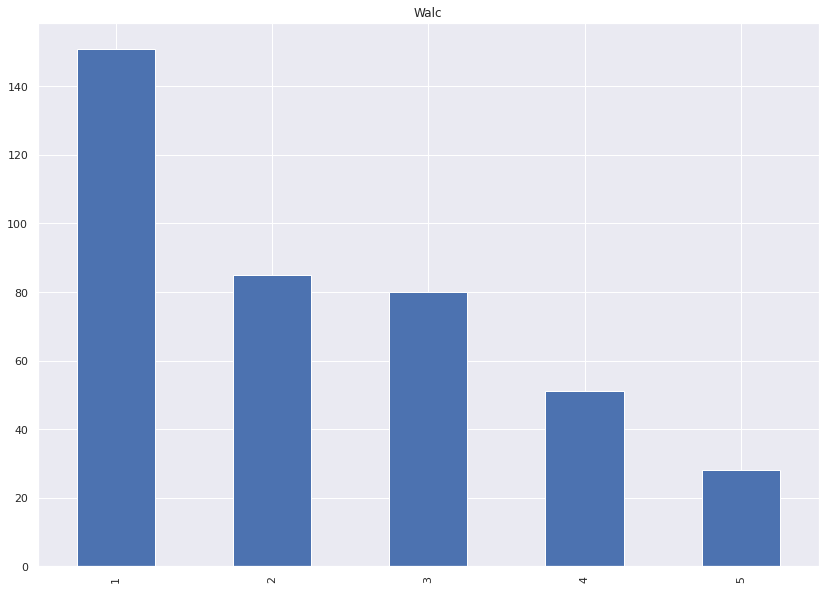

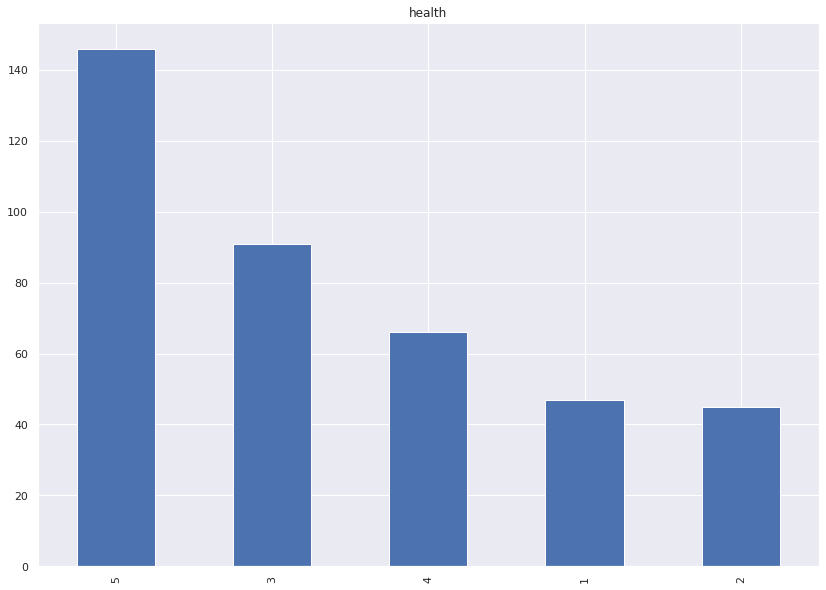

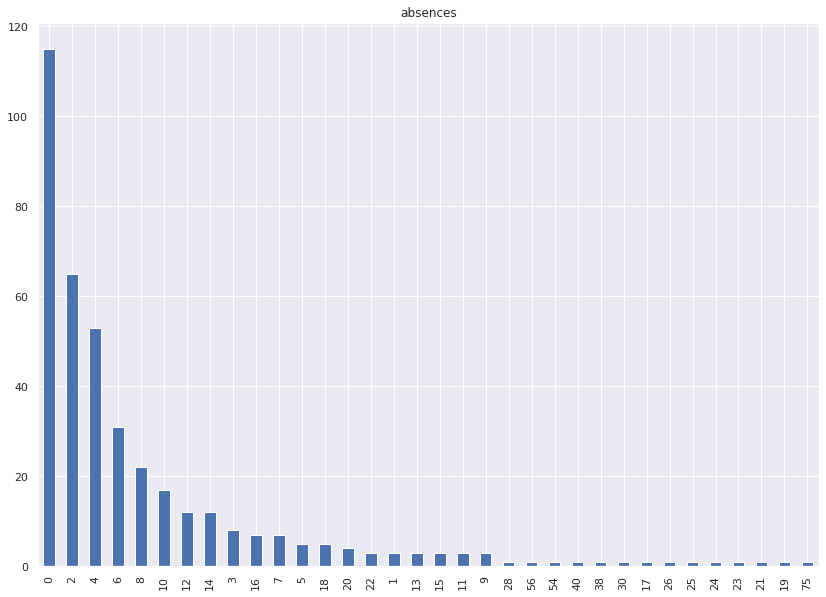

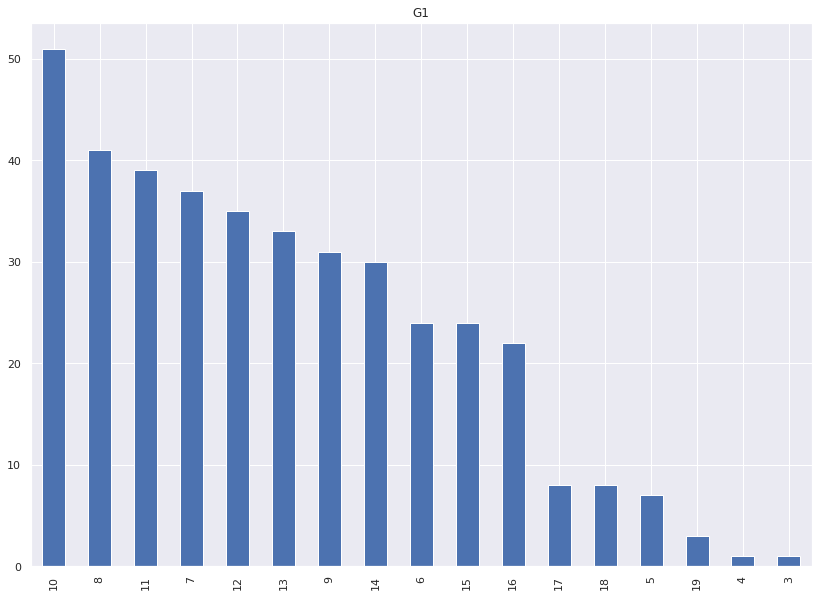

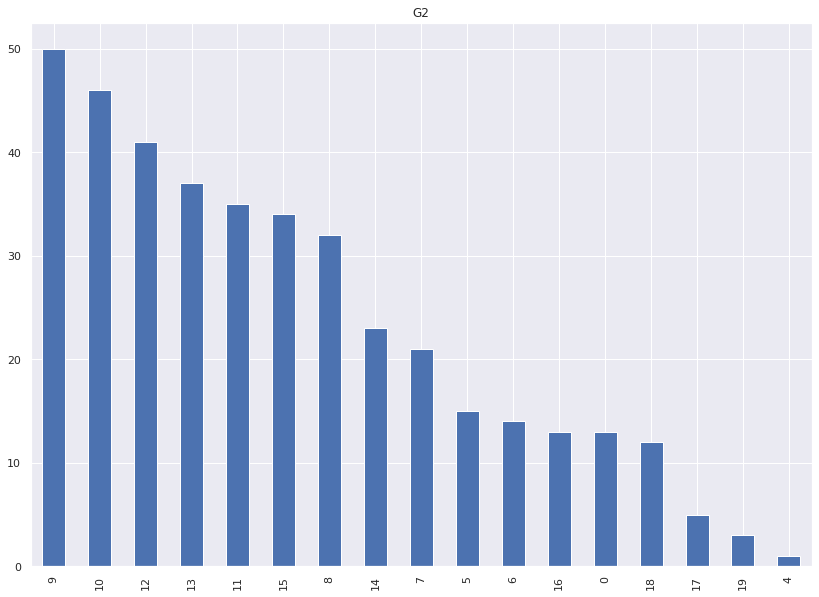

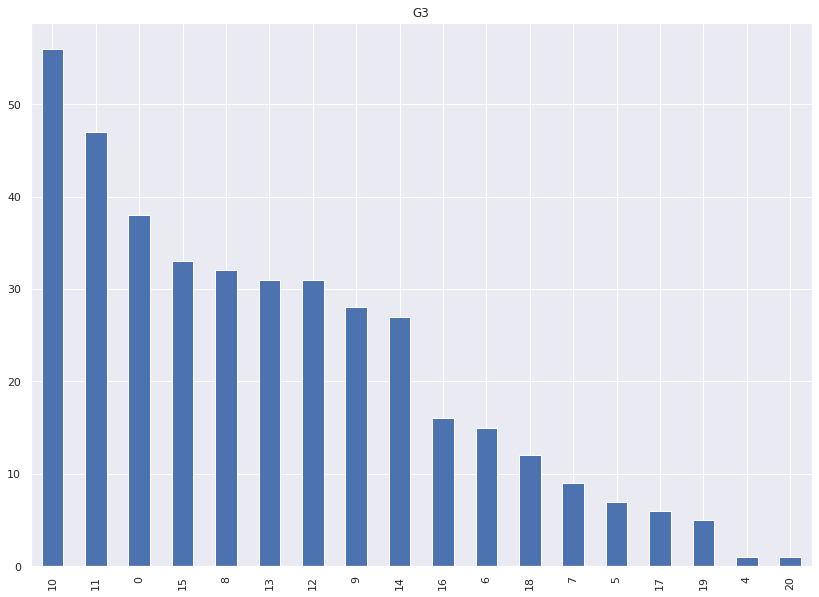

In [0]:
#Visualize Column Imbalances-- large output cell
for feature in eda_df.columns:
    eda_df[feature].value_counts().plot.bar()
    plt.title(feature)
    plt.show()

## Summary of imbalanced columns

- **School**   
   - Description: Student's School
   - NOIR Type: Nominal, binary  
   - Values are either "MS" or "GP" for the two schools included in the dataset's study. The two schools are "Mousinho da Silveira" and "Gabriel Pereira"
   - Counts between school are imbalanced ~7.6:1.
- **Address**
   - U = Urban (307) , R = Rural (88)
   - imbalanced ~3.5:1
- **Famsize**
   - LE3: <= 3 people (281) , GT3: > 3 people (114)
   - imbalanced ~ 2.5:1
- **Pstatus**
   - Parents cohabitative status
   - T= living together (354), A = living apart (41)
   - imbalanced ~13:1
- **Schoolsup**
   - School provides extra educational suppot
   - No (344), Yes (51)
   - imbalanced ~6.7:1
- **nursery**
   - Attended nursery school
   - Yes (314), No (81)
   - imbalanced ~3.9:1
- **higher**
   - Wants to take higher education
   - Yes (375), No (20)
   - imbalanced ~19:1
- **internet**
   - Has internet at home
   - Yes (329), No (66)
   - imbalanced ~5:1

### Target variable

In [0]:
#G3 is the grade or label we aim to predict
df1.groupBy('G3').count().orderBy('G3',ascending = True).show()

+---+-----+
| G3|count|
+---+-----+
|  0|   38|
|  4|    1|
|  5|    7|
|  6|   15|
|  7|    9|
|  8|   32|
|  9|   28|
| 10|   56|
| 11|   47|
| 12|   31|
| 13|   31|
| 14|   27|
| 15|   33|
| 16|   16|
| 17|    6|
| 18|   12|
| 19|    5|
| 20|    1|
+---+-----+



In [0]:
#find the mean G3 grade
df1.select([mean('G3')]).show()

+------------------+
|           avg(G3)|
+------------------+
|10.415189873417722|
+------------------+



Out[27]: <AxesSubplot:xlabel='G3', ylabel='Count'>

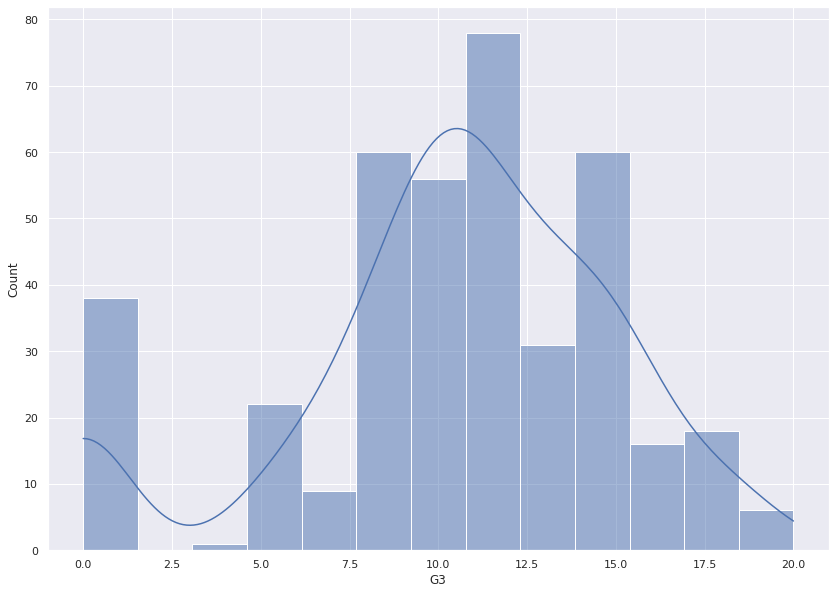

In [0]:
#G3 distribution
sns.histplot(x='G3', data=eda_df, kde=True)

In [0]:
df1.groupBy('school').agg(mean('G3')).show()

+------+------------------+
|school|           avg(G3)|
+------+------------------+
|    MS| 9.847826086956522|
|    GP|10.489971346704872|
+------+------------------+



In [0]:
df1.groupBy('studytime','higher').agg(mean('G3')).show()

+---------+------+------------------+
|studytime|higher|           avg(G3)|
+---------+------+------------------+
|        1|   yes|10.526881720430108|
|        1|    no| 6.333333333333333|
|        2|    no|               7.5|
|        3|   yes|              11.4|
|        4|   yes| 11.25925925925926|
|        2|   yes|10.284210526315789|
+---------+------+------------------+



In [0]:
df1.groupBy('internet','guardian').agg(mean('G3')).orderBy('avg(G3)',ascending = False).show()

+--------+--------+------------------+
|internet|guardian|           avg(G3)|
+--------+--------+------------------+
|     yes|  father|10.794871794871796|
|     yes|  mother|10.734513274336283|
|      no|  father|              10.0|
|      no|   other| 9.285714285714286|
|      no|  mother|  9.27659574468085|
|     yes|   other|               9.0|
+--------+--------+------------------+

